# 图像特征练习
*补充并完成本练习。*

我们已经看到，通过在输入图像的像素上训练线性分类器，从而在图像分类任务上达到一个合理的性能。在本练习中，我们将展示我们可以通过对线性分类器（不是在原始像素上，而是在根据原始像素计算出的特征上）进行训练来改善分类性能。

你将在此notebook中完成本练习的所有工作。

In [1]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 数据加载
与之前的练习类似，我们将从磁盘加载CIFAR-10数据。

In [3]:
from daseCV.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## 打印查看数据规模
print("X_train.shape:" ,X_train.shape)
print("y_train.shape:" ,y_train.shape)
print("X_val.shape:" ,X_val.shape)
print("y_val.shape:" ,y_val.shape )
print("X_test.shape:" ,X_test.shape)
print("y_test.shape:" ,y_test.shape)

X_train.shape: (49000, 32, 32, 3)
y_train.shape: (49000,)
X_val.shape: (1000, 32, 32, 3)
y_val.shape: (1000,)
X_test.shape: (1000, 32, 32, 3)
y_test.shape: (1000,)


## 特征提取
对于每一张图片我们将会计算它的方向梯度直方图（英語：Histogram of oriented gradient，简称HOG）以及在HSV颜色空间使用色相通道的颜色直方图。

简单来讲，HOG能提取图片的纹理信息而忽略颜色信息，颜色直方图则提取出颜色信息而忽略纹理信息。
因此，我们希望将两者结合使用而不是单独使用任一个。去实现这个设想是一个十分有趣的事情。

`hog_feature` 和 `color_histogram_hsv`两个函数都可以对单个图像进行运算并返回改图像的一个特征向量。
extract_features函数输入一个图像集合和一个特征函数列表然后对每张图片运行每个特征函数，
然后将结果存储在一个矩阵中，矩阵的每一列是单个图像的所有特征向量的串联。

In [4]:
from daseCV.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## 使用特征训练SVM
使用之前作业完成的多分类SVM代码来训练上面提取的特征。这应该比原始数据直接在SVM上训练会去的更好的效果。

In [16]:
# 使用验证集调整学习率和正则化强度

from daseCV.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-5,1e-4,1e-3,1e-2] ##1e-9的精确度太低了调整
regularization_strengths = [5e-1,5e1,5e2] ##（1e-8，5e4）(1e-6,5e6)精度也不高
##（1e-6，5e6）也不高
## (1e-7,5e3)(1e-5,5e5)也不行
## 5e4好像还是高了
## 1e-6继续调整
## 基本在5e-1下都可以达到44%，调整学习率


results = {}
best_val = -1
best_svm = None

################################################################################
# 你需要做的: 
# 使用验证集设置学习率和正则化强度。
# 这应该与你对SVM所做的验证相同；
# 将训练最好的的分类器保存在best_svm中。
# 你可能还想在颜色直方图中使用不同数量的bins。
# 如果你细心一点应该能够在验证集上获得接近0.44的准确性。    
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

iters = 2000

for learn_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learn_rate, reg=regularization_strength, num_iters=iters)

        y_train_pred = svm.predict(X_train_feats)
        accuracy_train = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        accuracy_val = np.mean(y_val == y_val_pred)

        results[(learn_rate, regularization_strength)] = (accuracy_train, accuracy_val)

        if best_val < accuracy_val:
            best_val = accuracy_val
            best_svm = svm


pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-05 reg 5.000000e-01 train accuracy: 0.416306 val accuracy: 0.406000
lr 1.000000e-05 reg 5.000000e+01 train accuracy: 0.415020 val accuracy: 0.417000
lr 1.000000e-05 reg 5.000000e+02 train accuracy: 0.414755 val accuracy: 0.415000
lr 1.000000e-04 reg 5.000000e-01 train accuracy: 0.459755 val accuracy: 0.453000
lr 1.000000e-04 reg 5.000000e+01 train accuracy: 0.413857 val accuracy: 0.413000
lr 1.000000e-04 reg 5.000000e+02 train accuracy: 0.414776 val accuracy: 0.416000
lr 1.000000e-03 reg 5.000000e-01 train accuracy: 0.498898 val accuracy: 0.481000
lr 1.000000e-03 reg 5.000000e+01 train accuracy: 0.413429 val accuracy: 0.401000
lr 1.000000e-03 reg 5.000000e+02 train accuracy: 0.366082 val accuracy: 0.366000
lr 1.000000e-02 reg 5.000000e-01 train accuracy: 0.497265 val accuracy: 0.491000
lr 1.000000e-02 reg 5.000000e+01 train accuracy: 0.364939 val accuracy: 0.351000
lr 1.000000e-02 reg 5.000000e+02 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy ach

In [17]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.474


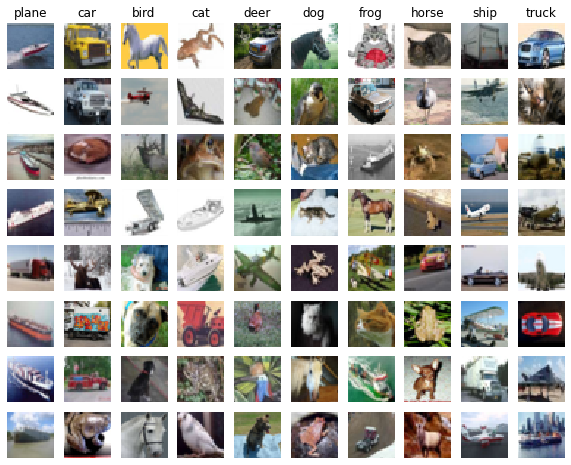

In [18]:
# 直观了解算法工作原理的一种重要方法是可视化它所犯的错误。
# 在此可视化中，我们显示了当前系统未正确分类的图像示例。
# 第一列显示的图像是我们的系统标记为“ plane”，但其真实标记不是“ plane”。

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

**问题 1:**

描述你看到的错误分类结果。你认为他们有道理吗？

$\color{blue}{\textit 答:}$ **有道理，例如第一列中的plane分类中错误分类的图像都含有于飞机相似或者相同的一些外观特征，例如说错误分类到plane中的轮船有与飞机相似形状的头部，错误分类带car中的卡车也含有car的大部分特征，4个轮子等，类似的其他错误分类的都有颜色、形状等等的外观相似的特点，所以造成的错误分类是有道理的**

## 图像特征神经网络
在之前的练习中，我们看到在原始像素上训练两层神经网络比线性分类器具有更好的分类精度。在这里，我们已经看到使用图像特征的线性分类器优于使用原始像素的线性分类器。
为了完整起见，我们还应该尝试在图像特征上训练神经网络。这种方法应优于以前所有的方法：你应该能够轻松地在测试集上达到55％以上的分类精度；我们最好的模型可达到约60％的精度。

In [19]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [29]:
from daseCV.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
best_acc = 0.0

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: 使用图像特征训练两层神经网络。
# 您可能希望像上一节中那样对各种参数进行交叉验证。
# 将最佳的模型存储在best_net变量中。                                             
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

iters_num = 2000
learning_rates = [5e-2,6e-2,7e-2,8e-2,9e-2] ##参考上述代码学习率数量级
regularization_strengths = [3e-3,3.5e-3,5e-3,5.5e-3,7e-3]

for lr in learning_rates:
    for reg in regularization_strengths:
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                          num_iters=iters_num,batch_size=200,
                          learning_rate=lr,learning_rate_decay=0.95,
                          reg=reg, verbose=False)
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = net
        print ("lr ",lr, "reg ", reg, "val accuracy:", val_acc)
print ("best validation accuracyachieved during cross-validation: ", best_acc)

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr  0.05 reg  0.003 val accuracy: 0.503
lr  0.05 reg  0.0035 val accuracy: 0.525
lr  0.05 reg  0.005 val accuracy: 0.54
lr  0.05 reg  0.0055 val accuracy: 0.547
lr  0.05 reg  0.007 val accuracy: 0.533
lr  0.06 reg  0.003 val accuracy: 0.57
lr  0.06 reg  0.0035 val accuracy: 0.576
lr  0.06 reg  0.005 val accuracy: 0.567
lr  0.06 reg  0.0055 val accuracy: 0.561
lr  0.06 reg  0.007 val accuracy: 0.564
lr  0.07 reg  0.003 val accuracy: 0.579
lr  0.07 reg  0.0035 val accuracy: 0.582
lr  0.07 reg  0.005 val accuracy: 0.577
lr  0.07 reg  0.0055 val accuracy: 0.572
lr  0.07 reg  0.007 val accuracy: 0.545
lr  0.08 reg  0.003 val accuracy: 0.586
lr  0.08 reg  0.0035 val accuracy: 0.59
lr  0.08 reg  0.005 val accuracy: 0.585
lr  0.08 reg  0.0055 val accuracy: 0.564
lr  0.08 reg  0.007 val accuracy: 0.556
lr  0.09 reg  0.003 val accuracy: 0.596
lr  0.09 reg  0.0035 val accuracy: 0.599
lr  0.09 reg  0.005 val accuracy: 0.572
lr  0.09 reg  0.0055 val accuracy: 0.563
lr  0.09 reg  0.007 val accuracy:

In [30]:
# 在测试集上运行得到的最好的神经网络分类器，应该能够获得55％以上的准确性。

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.542
